In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
with open('match.json') as file:
    data = json.load(file)

In [3]:
data['events'][0].keys()

dict_keys(['id', 'matchId', 'matchPeriod', 'minute', 'second', 'matchTimestamp', 'videoTimestamp', 'relatedEventId', 'type', 'location', 'team', 'opponentTeam', 'player', 'pass', 'shot', 'groundDuel', 'aerialDuel', 'infraction', 'carry', 'possession'])

In [4]:
# omzetten in dataframe
df = pd.DataFrame.from_dict(data['events'])

# df.head()

In [5]:
# type kolom splitsen in twee nieuwe
df[['primary', 'secondary']] = df['type'].apply(pd.Series)

# df.head(3)

In [6]:
# player kolom opsplitsen
player_detail = df['player'].apply(pd.Series)
df[['playerId', 'playerName', 'playerPosition']] = player_detail

# df.head(3)

In [7]:
# PASSES APART ZETTEN
# verzamel passes in nieuwe df
passes_df = df[df['primary'] == 'pass'].copy()
# passes_df['pass'][0].keys()

# pass kolom opsplitsen
pass_detail = passes_df['pass'].apply(pd.Series)
passes_df = pd.concat([passes_df, pass_detail], axis = 1)

# locations opsplitsen
passes_df[['originX', 'originY']] = passes_df['location'].apply(pd.Series)
passes_df[['endX', 'endY']] = passes_df['endLocation'].apply(pd.Series)

# teams opsplitsen
passes_df[['teamId', 'teamName', 'teamFormation']] = passes_df['team'].apply(pd.Series)
passes_df[['oppositionId', 'oppositionName', 'oppositionFormation']] = passes_df['opponentTeam'].apply(pd.Series)

# receiving player opsplitsen
passes_df[['recPlayerId', 'recPlayerName', 'recPlayerPosition']] = passes_df['recipient'].apply(pd.Series)

# passes_df.head()

In [8]:
# Overzicht van alle secondaries (kolom van lists) maken
secondaries = []

for record in passes_df['secondary']:
    for type in record:
        secondaries.append(type)

set(secondaries)

# Alle pass to penalty area verzamelen
penalty_entries_df = passes_df[passes_df['secondary'].apply(lambda x: 'pass_to_penalty_area' in x)]
# penalty_entries_df.head(3)

In [9]:
# WELKE SPELERS GEVEN MEESTE PASSES
# groeperen volgens naam en of pass aankomt
passes_by_player = passes_df.groupby(['playerName', 'accurate'])

# count geven van (niet) aangekomen passes per speler
passes_by_player = passes_by_player.count()['id'].reset_index().pivot(index = 'playerName', columns = 'accurate')

# NaN vervangen door 0
passes_by_player = passes_by_player.fillna(0)

# kolommen opkuisen
passes_by_player.columns = passes_by_player.columns.droplevel()
passes_by_player.columns = ['incomplete', 'complete']

# analyse
passes_by_player['total'] = passes_by_player['incomplete'] + passes_by_player['complete']
passes_by_player['percentage'] = ((passes_by_player['complete'] / passes_by_player['total']) * 100).round(1)
passes_by_player.reset_index(level = 0, inplace = True)

# sorteren
passes_by_player = passes_by_player.sort_values('percentage', ascending = False)
passes_by_player

,playerName,incomplete,complete,total,percentage
10,J. Grealish,0.0,19.0,19.0,100.0
4,C. Jones,2.0,40.0,42.0,95.2
2,Alisson,2.0,37.0,39.0,94.9
0,A. Laporte,3.0,51.0,54.0,94.4
21,Rodri,3.0,45.0,48.0,93.8
22,Rúben Dias,4.0,49.0,53.0,92.5
24,V. van Dijk,6.0,72.0,78.0,92.3
12,J. Matip,6.0,66.0,72.0,91.7
3,Bernardo Silva,5.0,45.0,50.0,90.0
7,Fabinho,4.0,27.0,31.0,87.1


In [10]:
# SHOTS DATAFRAME

# nieuwe dataframe maken voor shots
shots_df = df[df['primary'] == 'shot'].copy()
# shots_df['shot'][173].keys()

# kolommen opsplitsen
shot_detail = shots_df['shot'].apply(pd.Series)
shots_df = pd.concat([shots_df, shot_detail], axis = 1)

# locations opsplitsen
shots_df[['originX', 'originY']] = shots_df['location'].apply(pd.Series)

# teams opsplitsen
shots_df[['teamId', 'teamName', 'teamFormation']] = shots_df['team'].apply(pd.Series)
shots_df[['oppositionId', 'oppositionName', 'oppositionFormation']] = shots_df['opponentTeam'].apply(pd.Series)

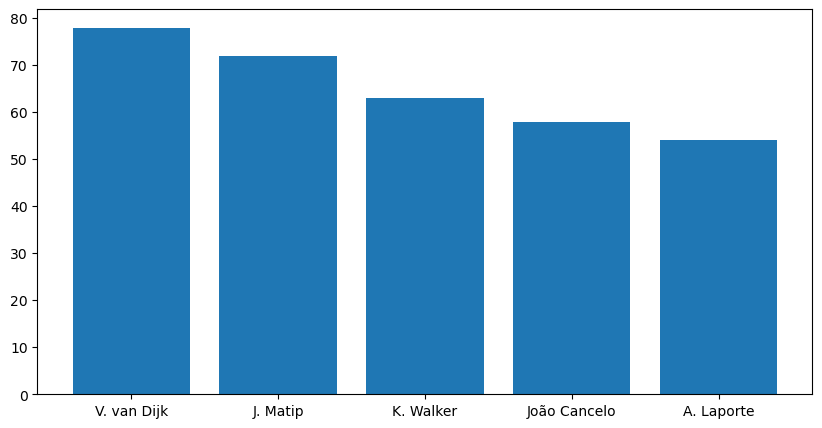

In [11]:
# TOP 5 PLAYER PASSES
# spelers ophalen
top_5_passes_df = passes_by_player.sort_values('total', ascending=False)[0:5]

# bar chart maken
fig = plt.figure(figsize = (10, 5))
plt.bar(top_5_passes_df['playerName'], top_5_passes_df['total'])
plt.show()

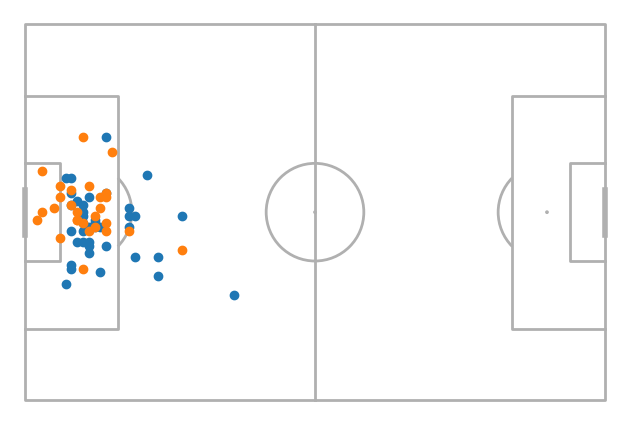

In [20]:
from mplsoccer import Pitch, VerticalPitch 

# KEEPER PASSES
# data filteren
alisson_passes = passes_df[passes_df['playerName'] == 'Alisson']
ederson_passes = passes_df[passes_df['playerName'] == 'Ederson']

# veld tekenen
pitch = Pitch(pitch_type = 'wyscout')
fig, ax = pitch.draw()

# data op veld zetten
pitch.scatter(alisson_passes['originX'], alisson_passes['originY'], ax=ax)
pitch.scatter(ederson_passes['originX'], ederson_passes['originY'], ax=ax)

plt.show()
